# Assignment8

You are to compete in the Real or Not:  NLP with Disaster Tweets competition on Kaggle.com.  https://www.kaggle.com/c/nlp-getting-started/notebooks

# Assignment Requirements

    Install the Python chakin package
    Obtain GloVe (and perhaps non-GloVe) embeddings.

    Load and run jump-start code for the assignment, which uses pretrained word vectors from GloVe.6B.50d, a vocabulary of 10,000 words, and movie review data.
    Revise the jump-start code to accommodate two pretrained word vectors and two vocabulary sizes. These represent the cells of a completely crossed 2-by-2 experimental design, defining four distinct language models.


    (Optional) Test two or more alternative RNN structures or hyperparameter settings.
    Build and evaluate at least four language models of the experimental design. For each cell in the design, compute classification accuracy in the test set.
    Evaluate the four language models and make recommendations to management.

# Management Problem
Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.

How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?

In [1]:
# Common imports for our work
import os 
import numpy as np
import tensorflow as tf
import time
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import re # regular expressions

import scipy
import os # Operation System
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
import tensorflow as tf
from datetime import datetime
#from __future__ import division, print_function, unicode_literals
import cv2
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from nltk.corpus import stopwords


# Python chakin package previously installed by 
#    pip install chakin
import chakin  

import json
import os
from collections import defaultdict

RANDOM_SEED = 9999

In [2]:
#chakin.search(lang='English')  # lists available indices in English

In [ ]:
#### Specify English embeddings file to download and install by index number, number of dimensions, and subfoder name
#### Note that GloVe 50-, 100-, 200-, and 300-dimensional folders are downloaded with a single zip download
#CHAKIN_INDEX = 11
#NUMBER_OF_DIMENSIONS = 50
#SUBFOLDER_NAME = "gloVe.6B"

In [ ]:
#DATA_FOLDER = "embeddings"
#ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
#ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
#UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
#if SUBFOLDER_NAME[-1] == "d":
#    GLOVE_FILENAME = os.path.join(
#        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
#else:
#    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
#        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))


#if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    ### GloVe by Stanford is licensed Apache 2.0:
    ###     https://github.com/stanfordnlp/GloVe/blob/master/LICENSE
    ###     http://nlp.stanford.edu/data/glove.twitter.27B.zip
    ###    Copyright 2014 The Board of Trustees of The Leland Stanford Junior University
#    print("Downloading embeddings to '{}'".format(ZIP_FILE))
#    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
#else:
#    print("Embeddings already downloaded.")

#if not os.path.exists(UNZIP_FOLDER):
#    import zipfile
#    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
#        ZIP_FILE = ZIP_FILE_ALT
#    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
#        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
#        zip_ref.extractall(UNZIP_FOLDER)
#else:
#    print("Embeddings already extracted.")

#print('\nRun complete')

##### After this step there should be
##### embeddings folder in the current working directory A
##### Directory called glove.6b within embeddings directory
##### 4 files within it

# Data Preparation:
     1)read-in data
     2)remove stopwords
     3)keep alphanumerics
     4)get label counts and plot
     5)train validation split

In [3]:
train_data = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/week 8 - Kaggle Disaster Tweets/nlp-getting-started/train.csv")

In [4]:
data2 = train_data[['text', 'target']]
print(data2.head)
stop = stopwords.words('english')

data2.text = data2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data2.head)

<bound method NDFrame.head of                                                    text  target
0     Our Deeds are the Reason of this #earthquake M...       1
1                Forest fire near La Ronge Sask. Canada       1
2     All residents asked to 'shelter in place' are ...       1
3     13,000 people receive #wildfires evacuation or...       1
4     Just got sent this photo from Ruby #Alaska as ...       1
...                                                 ...     ...
7608  Two giant cranes holding a bridge collapse int...       1
7609  @aria_ahrary @TheTawniest The out of control w...       1
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611  Police investigating after an e-bike collided ...       1
7612  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 2 columns]>
<bound method NDFrame.head of                                                    text  target
0     Our Deeds Reason #earthquake May ALLAH Forgive us       1
1                F

In [5]:
stop[:5]

['i', 'me', 'my', 'myself', 'we']

In [6]:


labels = np.asarray(data2.target)

observations =np.array([['Nondisasters', len(labels[labels==0])], ['Disasters',len(labels[labels==1])]])
df = pd.DataFrame(data= observations, columns=["Observations", "Counts"])
df.head()

,Observations,Counts
0,Nondisasters,4342
1,Disasters,3271


<AxesSubplot:xlabel='Observations', ylabel='Counts'>

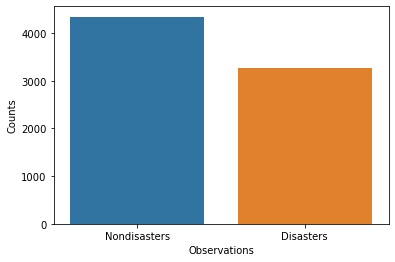

In [7]:

sns.barplot(x= df.Observations, y =df.Counts.astype('int32'))

In [ ]:
data2.text.dtype

In [10]:
data2.text = data2.text.str.replace('[^a-zA-Z]', ' ')

In [11]:
samples = data2.text
labels = data2.target

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(samples)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
x_train = samples[:-num_validation_samples]
x_val = samples[-num_validation_samples:]
y_train = labels[:-num_validation_samples]
y_val = labels[-num_validation_samples:]

In [ ]:
print('The proportion of disaster tweets in train is:', round(np.mean(y_train),3))
print('The proportion of disaster tweets in test is:', round(np.mean(y_val),3))

# Experiment V1000_Glove.6B

In [12]:
MAX_NB_WORDS = 1000
MAX_SEQUENCE_LENGTH = 150


vectorizer = TextVectorization(max_tokens=MAX_NB_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print('Selected %s unique tokens.' % len(word_index))

Selected 1000 unique tokens.


## Build Imbedding Matrix V1000_Glove.6B

In [ ]:
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

hits = 0
misses = 0

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print('Converted %d words (%d misses)' %(hits, misses))

In [ ]:
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

## Build, compile and train model (V1000_Glove.6B)

In [ ]:
e = Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, mask_zero=True)
opt = keras.optimizers.Adam(learning_rate=0.01)

GRU_model =keras.models.Sequential()
GRU_model.add(e)
GRU_model.add(keras.layers.GRU(128, return_sequences=True))

GRU_model.add(keras.layers.Flatten())
GRU_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
GRU_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
before_fit = datetime.now()
V1000_Glove_6B = GRU_model.fit(x_train, y_train, epochs=20)

after_fit = datetime.now()
elapsed =after_fit - before_fit
V1000_Glove_6B_duration = elapsed.total_seconds()



In [ ]:
# evaluate the model
V1000_Glove_6B_loss, V1000_Glove_6B_accuracy =GRU_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (V1000_Glove_6B_accuracy*100))
print('Loss: %f' %(V1000_Glove_6B_loss))

In [ ]:
pd.DataFrame(V1000_Glove_6B .history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Kaggle Test data
    1) Data read in and cleaning
    2) Build it's embedding matrix.
    3) Make predictions
    4) write dataframe out

## Experiment V1000_Glove.6B Summary

In [ ]:
V1000_Glove_6B_Summary = {
    'Experiment': ['V1000_Glove.6B'], 
    'Embedding': ['Glove.6B_50d'],
    'MissedVocab(%)': [misses/MAX_NB_WORDS*100], 
    'TrainDuration(s)': [V1000_Glove_6B_duration],
    'Accuracy': [V1000_Glove_6B_accuracy],
    'KaggleScore': ['N/A']
    
        }

V1000_Glove_6B_Summary_df = pd.DataFrame.from_dict(V1000_Glove_6B_Summary)
display(V1000_Glove_6B_Summary_df)

# Experiment V800_Glove.6B

In [13]:
samples = data2.text
labels = data2.target

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(samples)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
x_train = samples[:-num_validation_samples]
x_val = samples[-num_validation_samples:]
y_train = labels[:-num_validation_samples]
y_val = labels[-num_validation_samples:]

In [14]:
MAX_NB_WORDS = 800
MAX_SEQUENCE_LENGTH = 150


vectorizer = TextVectorization(max_tokens=MAX_NB_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print('Selected %s unique tokens.' % len(word_index))

Selected 800 unique tokens.


## Build Embedding Matrix V800_Glove.6B

In [15]:
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

hits = 0
misses = 0

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print('Converted %d words (%d misses)' %(hits, misses))

Found 400000 word vectors.
Converted 796 words (4 misses)


In [16]:
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

## Build, Compile, Train model (V800_Glove.6B)

In [17]:
e = Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, mask_zero=True)
opt = keras.optimizers.Adam(learning_rate=0.01)

GRU_model =keras.models.Sequential()
GRU_model.add(e)
GRU_model.add(keras.layers.GRU(128, return_sequences=True))

GRU_model.add(keras.layers.Flatten())
GRU_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
GRU_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
before_fit = datetime.now()
V800_Glove_6B = GRU_model.fit(x_train, y_train, epochs=20)

after_fit = datetime.now()
elapsed =after_fit - before_fit
V800_Glove_6B_duration = elapsed.total_seconds()


In [ ]:
V800_Glove_6B_loss, V800_Glove_6B_accuracy =GRU_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (V800_Glove_6B_accuracy*100))
print('Loss: %f' %(V800_Glove_6B_loss))

In [ ]:
pd.DataFrame(V800_Glove_6B .history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Experiment V1000_Glove.Twitter

In [ ]:
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
V1800_Glove_6B_Summary = {
    'Experiment': ['V800_Glove.6B'], 
    'Embedding': ['Glove.6B_50d'],
    'MissedVocab(%)': [misses/MAX_NB_WORDS*100], 
    'TrainDuration(s)': [V800_Glove_6B_duration],
    'Accuracy': [V800_Glove_6B_accuracy],
    'KaggleScore': ['N/A']
    
        }

V800_Glove_6B_Summary_df = pd.DataFrame.from_dict(V800_Glove_6B_Summary)
display(V800_Glove_6B_Summary_df)

In [ ]:
#### Summary Table
print('------------------------------- Summary Table -------------------------------')

Management Problem
- Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.
- How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?


#### REPORT/FINDINGS: 
(1) A summary and problem definition for management; 

(2) Discussion of the research design, measurement and statistical methods, traditional and machine learning methods employed 

(3) Overview of programming work; 

(4) Review of results with recommendations for management.
